In [ ]:
# Import libraries
import os
import time
import tqdm
import torch
import IPython
import torchvision
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/NMA_DL_2022

/content/gdrive/My Drive/NMA_DL_2022


In [ ]:
# @title Determine number of classes
num_classes = 2

In [ ]:
# @title Download and transform images into dataset
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))
dataset = ImageFolder('Muller_train_image',
                      transform=train_transform)

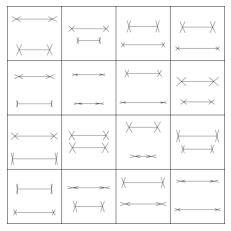

In [ ]:
# @title Display Example Images
image_count = len(dataset)
train_indices = []
test_indices = []
for i in range(image_count):
  # Put ten percent of the images in the test set
  if random.random() < .1:
    test_indices.append(i)
  else:
    train_indices.append(i)

test_set = torch.utils.data.Subset(dataset, test_indices)
train_set = torch.utils.data.Subset(dataset, train_indices)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True,)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size)

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show images
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
#@title Set device (GPU or CPU). Execute `set_device()` { display-mode: "form" }
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
# Reset final fully connected layer, number of classes = types of Pokemon = 9
resnet.fc = nn.Linear(num_ftrs, num_classes)
DEVICE = set_device()
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

GPU is enabled in this notebook.


In [ ]:
# @title Finetune ResNet

pretrained_accs = []
for epoch in tqdm.tqdm(range(200)):
  # Train loop
  for batch in train_loader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(test_set)
    for batch in test_loader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total_correct += num_correct

    # Plot accuracy
    pretrained_accs.append(total_correct.cpu() / total)
    plt.figure('test_accuracy_rate')
    plt.plot(pretrained_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('ML illusion prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    
  plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]